In [1]:
! nvidia-smi

Thu Feb 16 15:05:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8    10W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   

In [2]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32))])

batch_size = 32

In [6]:
torchvision.datasets

<module 'torchvision.datasets' from 'C:\\Users\\posso\\miniconda3\\envs\\GIM\\lib\\site-packages\\torchvision\\datasets\\__init__.py'>

In [7]:
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset.__len__(), valset.__len__(), testset.__len__()

(40000, 10000, 10000)

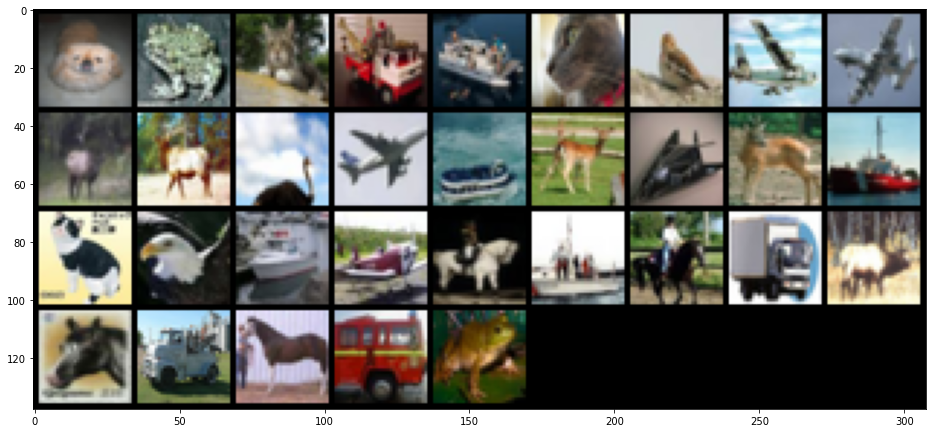

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [10]:
# print labels
for i in range(batch_size//nrow + 1 if batch_size % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

5   6   3   9   8   3   2   0   0  
4   4   2   0   8   4   0   4   8  
3   2   8   0   7   8   7   9   4  
7   9   7   9   6  


In [11]:
import torch.nn as nn
import torch.nn.functional as F

pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
net.classifier[1] = nn.Linear(1280, 10)
net = net.to(device)

In [12]:
#from torchsummary import summary
#summary(net, (3, 100, 100), batch_size = 32)
from torchinfo import summary as summary_info
print(summary_info(net, input_size = (32, 3, 32, 32)))
net = net.to(device)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            --                        --
├─Sequential: 1-1                                       [32, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [32, 24, 16, 16]          --
│    │    └─Conv2d: 3-1                                 [32, 24, 16, 16]          648
│    │    └─BatchNorm2d: 3-2                            [32, 24, 16, 16]          48
│    │    └─SiLU: 3-3                                   [32, 24, 16, 16]          --
│    └─Sequential: 2-2                                  [32, 24, 16, 16]          --
│    │    └─FusedMBConv: 3-4                            [32, 24, 16, 16]          5,232
│    │    └─FusedMBConv: 3-5                            [32, 24, 16, 16]          5,232
│    └─Sequential: 2-3                                  [32, 48, 8, 8]            --
│    │    └─FusedMBConv: 3-6                         

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

epochs = 20

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './EfficientNet_V2_S_CIFAR10.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    
    # print statistics
    #print(confusion_matrix(y_labels, y_predict))
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    #print(confusion_matrix(y_labels, y_predict))
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 1.13, acc: 60.93%, f1-score: 60.79%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.067, acc: 62.88%, f1-score: 62.59%, support: 10000
epoch 2 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.8931, acc: 69.88%, f1-score: 69.78%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.9024, acc: 68.76%, f1-score: 68.82%, support: 10000
epoch 3 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.7297, acc: 75.14%, f1-score: 75.08%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.8418, acc: 71.51%, f1-score: 71.39%, support: 10000
epoch 4 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.629, acc: 78.77%, f1-score: 78.72%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.7887, acc: 73.88%, f1-score: 73.96%, support: 10000
epoch 5 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.5173, acc: 82.49%, f1-score: 82.46%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.7522, acc: 75.41%, f1-score: 75.24%, support: 10000
epoch 6 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.4154, acc: 85.98%, f1-score: 85.97%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.7717, acc: 75.92%, f1-score: 75.79%, support: 10000
epoch 7 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.3494, acc: 88.24%, f1-score: 88.23%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.7721, acc: 75.79%, f1-score: 75.84%, support: 10000
epoch 8 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.2803, acc: 90.49%, f1-score: 90.49%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.8402, acc: 75.84%, f1-score: 75.86%, support: 10000
epoch 9 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.2259, acc: 92.41%, f1-score: 92.41%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.8597, acc: 76.72%, f1-score: 76.6%, support: 10000
epoch 10 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.1926, acc: 93.62%, f1-score: 93.61%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.8946, acc: 75.96%, f1-score: 76.04%, support: 10000
epoch 11 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.1626, acc: 94.59%, f1-score: 94.59%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.9037, acc: 76.92%, f1-score: 76.92%, support: 10000
epoch 12 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.1438, acc: 95.25%, f1-score: 95.25%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.9393, acc: 76.57%, f1-score: 76.29%, support: 10000
epoch 13 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.1161, acc: 96.16%, f1-score: 96.16%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 0.987, acc: 77.32%, f1-score: 77.39%, support: 10000
epoch 14 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.09788, acc: 96.68%, f1-score: 96.68%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.037, acc: 76.35%, f1-score: 76.32%, support: 10000
epoch 15 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.08595, acc: 97.16%, f1-score: 97.16%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.143, acc: 76.77%, f1-score: 76.9%, support: 10000
epoch 16 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.07883, acc: 97.36%, f1-score: 97.36%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.106, acc: 77.21%, f1-score: 77.26%, support: 10000
epoch 17 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.07498, acc: 97.56%, f1-score: 97.57%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.029, acc: 77.42%, f1-score: 77.5%, support: 10000
epoch 18 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.07702, acc: 97.52%, f1-score: 97.52%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.005, acc: 75.69%, f1-score: 75.74%, support: 10000
epoch 19 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.08211, acc: 97.27%, f1-score: 97.27%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.092, acc: 77.77%, f1-score: 77.72%, support: 10000
epoch 20 
Training ...


  0%|          | 0/1250 [00:00<?, ?it/s]

training loss: 0.06053, acc: 98.05%, f1-score: 98.05%, support: 40000
validating ...


  0%|          | 0/313 [00:00<?, ?it/s]

validation loss: 1.131, acc: 77.66%, f1-score: 77.59%, support: 10000
Finished Training


In [17]:
min_val_loss

0.7521617046465128

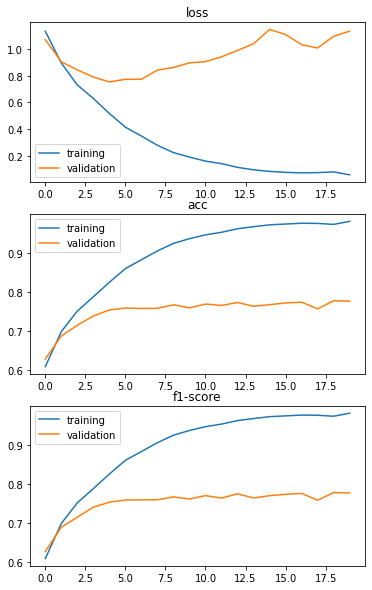

In [18]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [19]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/313 [00:00<?, ?it/s]

testing loss: 0.7498
              precision    recall  f1-score   support

           0     0.7900    0.7750    0.7824      1000
           1     0.8829    0.8290    0.8551      1000
           2     0.6212    0.7280    0.6703      1000
           3     0.6374    0.5010    0.5610      1000
           4     0.7492    0.7140    0.7312      1000
           5     0.6431    0.6560    0.6495      1000
           6     0.8112    0.8120    0.8116      1000
           7     0.8000    0.8040    0.8020      1000
           8     0.8314    0.8530    0.8421      1000
           9     0.7816    0.8730    0.8248      1000

    accuracy                         0.7545     10000
   macro avg     0.7548    0.7545    0.7530     10000
weighted avg     0.7548    0.7545    0.7530     10000



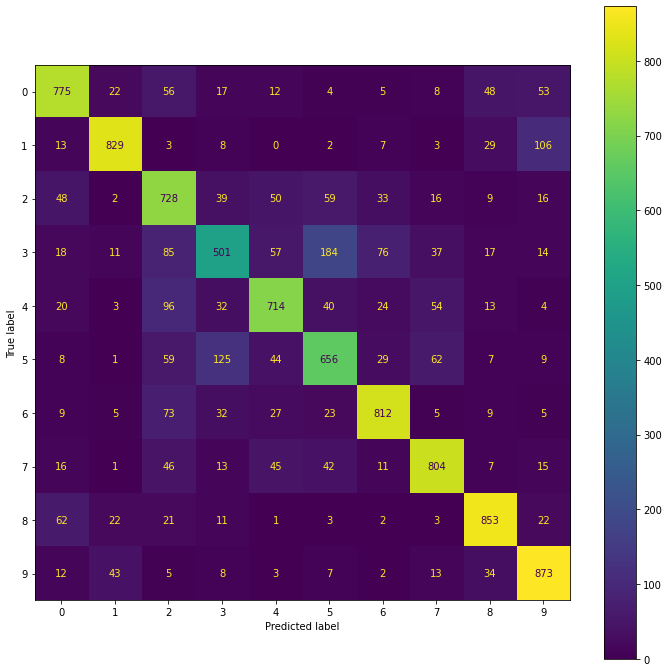

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show()